In [1]:
%config Inline_Backend.figure_format = "svg"
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import glob

Algumas terminologias úteis:
- Sample: Cada ficheiro csv ou h5
- Evento: Cada linha das samples

Questões:
- O sinal representa nova física e o background processos já conhecidos da física de partículas? Caso contrário, qual o motivo da descrepância entre a quantidade de dados de sinal e background que utilizamos?
- Se os dados não fossem gerados, mas antes retirados diretamente de resultados de medições, como dividiríamos os dados em samples e como obteríamos as cross-sections de cada sample?

## Funções auxiliares de manipulação de dados

In [2]:
def filter_event(event, btag_cols=[], lepton_cols=[]):
    """
    Verifica se um evento apresenta pelo menos:
    - 1 b-tag
    - 2 leptões
    
    btag_cols -> [String]: lista de colunas com a contagem de btags
    lepton_cols -> [String]: lista de colunas com a contagem de leptões
    
    return -> Bool: resultado da verificação
    """
    
    # Calcular o nº de b-tags e leptões
    b_tags = sum([event[col] for col in btag_cols])
    leptons = sum([event[col] for col in lepton_cols])
    
    return (b_tags>0 and leptons>1)
  

def merge_files(path="", form="csv", del_cols=[], btag_cols=[], lepton_cols=[], cut=True):
    """
    Coloca todas as samples de uma diretoria num único dataframe
    Filtra os eventos de acordo com uma certa verificação
    Calcula os pesos de cada evento
    Filtra as colunas com dados extra
    
    path -> string: diretoria dos dados
    form -> string: formato dos dados a importar (csv ou h5)
    del_cols -> [string]: lista de colunas a serem eliminadas dos files
    b_tag_cols -> [string]: lista de colunas de b-tag
    leptons_cols -> [string]: lista de colunas com a contagem de leptões
    cut -> Bool: Booleano referente a querer executar os cuts das samples
    
    return -> pandas dataframe: dataframe resultante da concatenação e alteração dos files
    """
    
    # Guardar as samples numa lista de dataframes
    total_drop, total_len = 0, 0
    bkgd_data, files = [], glob.glob(path + "*." + form)
    for file in tqdm(files, total=len(files), desc="Processing Samples"):
        # Ler a sample
        if form == "csv": df = pd.read_csv(file, header=0)
        elif form == "h5": df = pd.read_hdf(file)
          
        # Sort dos dataframes
        df.sort_index(axis=1, inplace=True)
        
        # Filtrar os eventos da sample
        if cut:
            drop_list = [i for i in range(len(df)) if not filter_event(df.loc[i], btag_cols, lepton_cols)]
            tqdm.write(f"File: {file} | Original Size: {len(df)} | Drop_Ratio: {len(drop_list)/len(df):.3f}")
            total_drop, total_len = total_drop + len(drop_list), total_len + len(df)
            df.drop(drop_list, inplace=True)
        
        # Calcular gen_weights
        df["gen_xsec"] = df["gen_xsec"].mean()/df.shape[0]
        df.rename(columns={"gen_xsec":"gen_weights"}, inplace=True)
        
        # Remover colunas de dados extra
        del_cols = [col for col in del_cols if col in df]
        df.drop(del_cols, axis=1, inplace=True)
        bkgd_data.append(df)
                
    # Concatenar a lista de samples
    if cut: print(f"Total Drop Ratio: {total_drop/total_len:.3f}")
    if len(bkgd_data) > 1: bkgd_data = pd.concat(bkgd_data)
    else: bkgd_data = bkgd_data[0]
    
    return bkgd_data

## Gerar os dataframes e np_arrays dos dados

In [3]:
# Variáveis de controlo da criação do dataframe de background
data_path = "Data/dileptonic/"
del_cols = ["MissingET_Eta", "gen_decay1", "gen_decay2", "gen_sample", "gen_filter", "gen_decay_filter"]
btag_cols = ["Jet1_BTag", "Jet2_BTag", "Jet3_BTag", "Jet4_BTag", "Jet5_BTag"]
lepton_cols = ["Electron_Multi", "Muon_Multi"]

In [4]:
# Criar o dataframe de background
bkgd_data = merge_files(data_path, "csv", del_cols, btag_cols, lepton_cols)
bkgd_data.describe()

Processing Samples:   6%|▌         | 1/18 [01:34<26:54, 94.95s/it]

File: Data/dileptonic/ttbarH_2L.csv | Original Size: 500000 | Drop_Ratio: 0.698


Processing Samples:   6%|▌         | 1/18 [14:15<26:54, 94.95s/it]

File: Data/dileptonic/Zbb_2L.csv | Original Size: 4000000 | Drop_Ratio: 0.899


Processing Samples:  17%|█▋        | 3/18 [15:50<58:39, 234.64s/it]  

File: Data/dileptonic/WZ_2L.csv | Original Size: 500000 | Drop_Ratio: 0.977


Processing Samples:  22%|██▏       | 4/18 [17:25<44:59, 192.81s/it]

File: Data/dileptonic/ttbar_2L.csv | Original Size: 500000 | Drop_Ratio: 0.694


Processing Samples:  22%|██▏       | 4/18 [30:02<44:59, 192.81s/it]

File: Data/dileptonic/ttbarj_2L.csv | Original Size: 4000000 | Drop_Ratio: 0.712


Processing Samples:  33%|███▎      | 6/18 [30:12<51:15, 256.30s/it]  

File: Data/dileptonic/topZj_2L_train.csv | Original Size: 50000 | Drop_Ratio: 0.691


Processing Samples:  33%|███▎      | 6/18 [42:49<51:15, 256.30s/it]

File: Data/dileptonic/Zbj_2L.csv | Original Size: 4000000 | Drop_Ratio: 0.788


Processing Samples:  39%|███▉      | 7/18 [55:36<1:14:34, 406.81s/it]

File: Data/dileptonic/Zjj_2L.csv | Original Size: 4000000 | Drop_Ratio: 0.978


Processing Samples:  50%|█████     | 9/18 [55:56<54:55, 366.18s/it]  

File: Data/dileptonic/ttbarW_2L.csv | Original Size: 100000 | Drop_Ratio: 0.668


Processing Samples:  56%|█████▌    | 10/18 [56:15<34:57, 262.18s/it]

File: Data/dileptonic/topZj_2L.csv | Original Size: 100000 | Drop_Ratio: 0.693


Processing Samples:  56%|█████▌    | 10/18 [1:08:48<34:57, 262.18s/it]

File: Data/dileptonic/ttbarb_2L.csv | Original Size: 3899999 | Drop_Ratio: 0.690


Processing Samples:  67%|██████▋   | 12/18 [1:08:58<28:57, 289.53s/it]

File: Data/dileptonic/ttbarZ_2L_train.csv | Original Size: 50000 | Drop_Ratio: 0.584


Processing Samples:  72%|███████▏  | 13/18 [1:09:08<17:07, 205.53s/it]

File: Data/dileptonic/ttbarZ_2L_test.csv | Original Size: 50000 | Drop_Ratio: 0.585


Processing Samples:  78%|███████▊  | 14/18 [1:09:17<09:47, 146.82s/it]

File: Data/dileptonic/topZj_2L_test.csv | Original Size: 50000 | Drop_Ratio: 0.694


Processing Samples:  83%|████████▎ | 15/18 [1:10:55<06:35, 131.92s/it]

File: Data/dileptonic/WW_2L.csv | Original Size: 500000 | Drop_Ratio: 0.994


Processing Samples:  89%|████████▉ | 16/18 [1:12:31<04:02, 121.36s/it]

File: Data/dileptonic/ZZ_2L.csv | Original Size: 500000 | Drop_Ratio: 0.948


Processing Samples:  94%|█████████▍| 17/18 [1:12:51<01:30, 90.86s/it] 

File: Data/dileptonic/ttbarZ_2L.csv | Original Size: 100000 | Drop_Ratio: 0.584


Processing Samples: 100%|██████████| 18/18 [1:13:01<00:00, 243.42s/it]


File: Data/dileptonic/topWZ_2L.csv | Original Size: 50000 | Drop_Ratio: 0.626
Total Drop Ratio: 0.815


,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT,gen_weights,MissingET_Eta
count,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,...,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,193433.000000
mean,1.144244e-04,3.859111e+01,1.084335e-03,6.578391e-05,9.697738e+00,1.264110e-05,8.245510e-01,4.101399e-04,7.257056e+00,3.065015e+01,...,4.498187e-04,5.110581e+01,-6.180218e-04,4.014672e-05,1.617111e+01,-3.028545e-05,1.188113e+00,3.605171e+02,1.113686e-04,-0.007026
std,8.418525e-01,4.644635e+01,1.370063e+00,5.749829e-01,2.003727e+01,9.116318e-01,8.106689e-01,3.812480e-01,2.411029e+01,9.142469e+01,...,9.935177e-01,4.688299e+01,1.571220e+00,7.781081e-01,2.316157e+01,1.194959e+00,8.122001e-01,1.834634e+02,5.202477e-04,3.180667
min,-2.499997e+00,0.000000e+00,-3.141592e+00,-2.499985e+00,0.000000e+00,-3.141592e+00,0.000000e+00,-4.000467e+00,-5.285799e-05,0.000000e+00,...,-2.399985e+00,0.000000e+00,-3.141592e+00,-2.399981e+00,0.000000e+00,-3.141588e+00,0.000000e+00,4.447565e+01,1.304437e-07,-10.116375
25%,-1.928962e-01,0.000000e+00,-3.839418e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-5.635411e-01,1.028139e+01,-1.048443e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.310312e+02,5.842474e-07,-2.933672
50%,0.000000e+00,2.859756e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.753570e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.254956e+02,2.374618e-05,-0.037403
75%,1.953454e-01,6.321899e+01,3.898618e-01,0.000000e+00,1.121624e+01,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.642138e-01,7.347187e+01,1.046109e+00,0.000000e+00,3.038062e+01,0.000000e+00,2.000000e+00,4.480336e+02,2.458480e-05,2.928016
max,2.499979e+00,1.451913e+03,3.141593e+00,2.499981e+00,5.076544e+02,3.141575e+00,5.000000e+00,3.873402e+00,5.243948e+02,1.723009e+03,...,2.399990e+00,1.249431e+03,3.141587e+00,2.399961e+00,6.135786e+02,3.141591e+00,4.000000e+00,3.903838e+03,3.651510e-03,11.275425


In [5]:
# Variáveis de controlo da criação do dataframe de sinal
data_path = "Data/FCNC/"

# Criar o dataframe de sinal
fcnc_data = merge_files(data_path, "h5", del_cols, btag_cols, lepton_cols)
fcnc_data.describe()

Processing Samples: 100%|██████████| 1/1 [01:32<00:00, 92.43s/it]


File: Data/FCNC/tZFCNC.h5 | Original Size: 496629 | Drop_Ratio: 0.606
Total Drop Ratio: 0.606


,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,MissingET_Phi,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT,gen_weights
count,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,...,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,1.957250e+05
mean,-0.002376,93.874797,0.002506,-0.001356,24.843815,-0.000378,1.003965,-0.000878,39.842755,214.031343,...,-0.011142,-0.002890,122.098796,0.008965,-0.002141,36.443064,0.000233,1.373611,608.585528,3.264224e-09
std,0.956811,135.176460,1.411901,0.677618,50.790100,1.049370,0.959648,0.882671,48.378385,246.652396,...,1.811996,1.084205,147.214662,1.571437,0.853159,58.101179,1.274687,1.002467,371.896309,6.990108e-21
min,-2.499965,0.000000,-3.141324,-2.499727,0.000000,-3.141587,0.000000,-3.494491,-0.000061,0.000000,...,-3.141550,-2.399990,0.000000,-3.141585,-2.399888,0.000000,-3.141572,0.000000,51.668472,3.264224e-09
25%,-0.343061,0.000000,-0.539507,0.000000,0.000000,0.000000,0.000000,-0.127633,0.000000,0.000000,...,-1.575856,-0.684100,0.000000,-1.031103,0.000000,0.000000,0.000000,0.000000,354.401245,3.264224e-09
50%,0.000000,43.226986,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.294422,216.051682,...,-0.017987,0.000000,79.353065,0.000000,0.000000,0.000000,0.000000,1.000000,512.929443,3.264224e-09
75%,0.332078,138.506805,0.549541,0.000000,32.493484,0.000000,2.000000,0.119289,91.306366,354.365540,...,1.557150,0.672683,175.863571,1.061248,0.000000,53.818260,0.000000,2.000000,753.832581,3.264224e-09
max,2.499960,2124.003174,3.141387,2.499523,998.448608,3.141527,5.000000,3.708754,732.435364,2939.618408,...,3.141546,2.399966,2646.508301,3.141582,2.399788,1217.265381,3.141448,5.000000,4926.052246,3.264224e-09


Labels dos dados:
- Background: 0
- Sinal: 1

In [14]:
# Dar labels aos dados
bkgd_data["Label"] = 0
fcnc_data["Label"] = 1

# Guardar dados
bkgd_data.to_hdf("Data/Background.h5", key="bkgd")
fcnc_data.to_hdf("Data/FCNC.h5", key="fcnc")

In [15]:
bkgd_data

,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT,gen_weights,Label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.482720,158.952774,595.341003,...,0.443487,407.632080,-0.755916,0.785445,292.118774,2.734722,2,1212.756226,1.304437e-07,0
1,-2.060421,30.932735,-1.365277,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,...,-2.106180,54.675926,2.572098,0.000000,0.000000,0.000000,1,352.939209,1.304437e-07,0
2,-1.025947,40.282574,-1.773086,0.288352,26.201660,-0.694144,2,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,419.889740,1.304437e-07,0
3,1.084838,82.556099,2.932473,0.000000,0.000000,0.000000,1,0.969367,103.233589,318.344971,...,-0.059388,43.076065,-2.346566,0.000000,0.000000,0.000000,1,610.762146,1.304437e-07,0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,...,1.464516,80.244713,-2.605392,1.797688,23.799982,2.562366,2,291.874695,1.304437e-07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.856027,93.484222,328.922668,...,0.810523,198.751053,-1.511395,0.853296,139.109955,-0.960849,2,786.891846,4.285867e-07,0
49987,0.803573,115.304886,-2.760615,0.394527,63.806351,2.506781,2,-1.067106,38.329311,221.202927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,555.961548,4.285867e-07,0
49988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.674905,96.106346,309.991272,...,-0.689148,100.474754,0.768939,1.090064,10.157313,-2.003914,2,785.676025,4.285867e-07,0
49992,0.311730,141.319260,2.593879,0.543723,120.261703,1.999698,3,0.436267,84.218849,255.645981,...,0.648881,26.983477,-0.882595,0.000000,0.000000,0.000000,1,753.086426,4.285867e-07,0


## Plots

### Plots sem cuts

In [ ]:
# Variáveis de controlo da criação do dataframe de background
data_path = "Data/dileptonic/"
del_cols = ["MissingET_Eta", "gen_decay1", "gen_decay2", "gen_sample", "gen_filter", "gen_decay_filter"]

In [ ]:
# Criar dataframe de background
bkgd_data = merge_files(data_path, "csv", del_cols, cut=False)
bkgd_data

In [ ]:
# Criar dataframe de sinal
data_path = "Data/FCNC/"
fcnc_data = merge_files(data_path, "h5", del_cols, cut=False)

In [ ]:
# Variáveis de ajuste dos plots
num_cols, bins = 5, 50

# Criar os plots
num_rows = int(np.ceil((len(list(fcnc_data.columns)) - 1) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterar e plotar cada coluna de dados
for i, column in enumerate(fcnc_data.columns):
    if fcnc_data.columns[i] != "gen_weights":
        # Definir a range do histograma
        hist_min = min(fcnc_data[column].min(), bkgd_data[column].min())
        hist_max = max(fcnc_data[column].max(), bkgd_data[column].max())
        hist_range = (hist_min, hist_max)

        # Dar plot aos dados
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(fcnc_data.columns[i])
        axs[row, col].hist(bkgd_data[column], bins=50, label="bkgd", alpha=0.8, weights=bkgd_data["gen_weights"], range=hist_range)
        axs[row, col].hist(fcnc_data[column], bins=50, label="fcnc", alpha=0.8, weights=fcnc_data["gen_weights"], range=hist_range)
        axs[row, col].set_yscale("log")
        axs[row, col].legend()
    
plt.show()

### Plots com cuts

In [ ]:
# Importar dados pré-processados
bkgd_data = pd.read_hdf("Data/Processed_Data.h5", key="bkgd")
fcnc_data = pd.read_hdf("Data/Processed_Data.h5", key="fcnc")

In [ ]:
bkgd_data.describe()

In [ ]:
fcnc_data.describe()

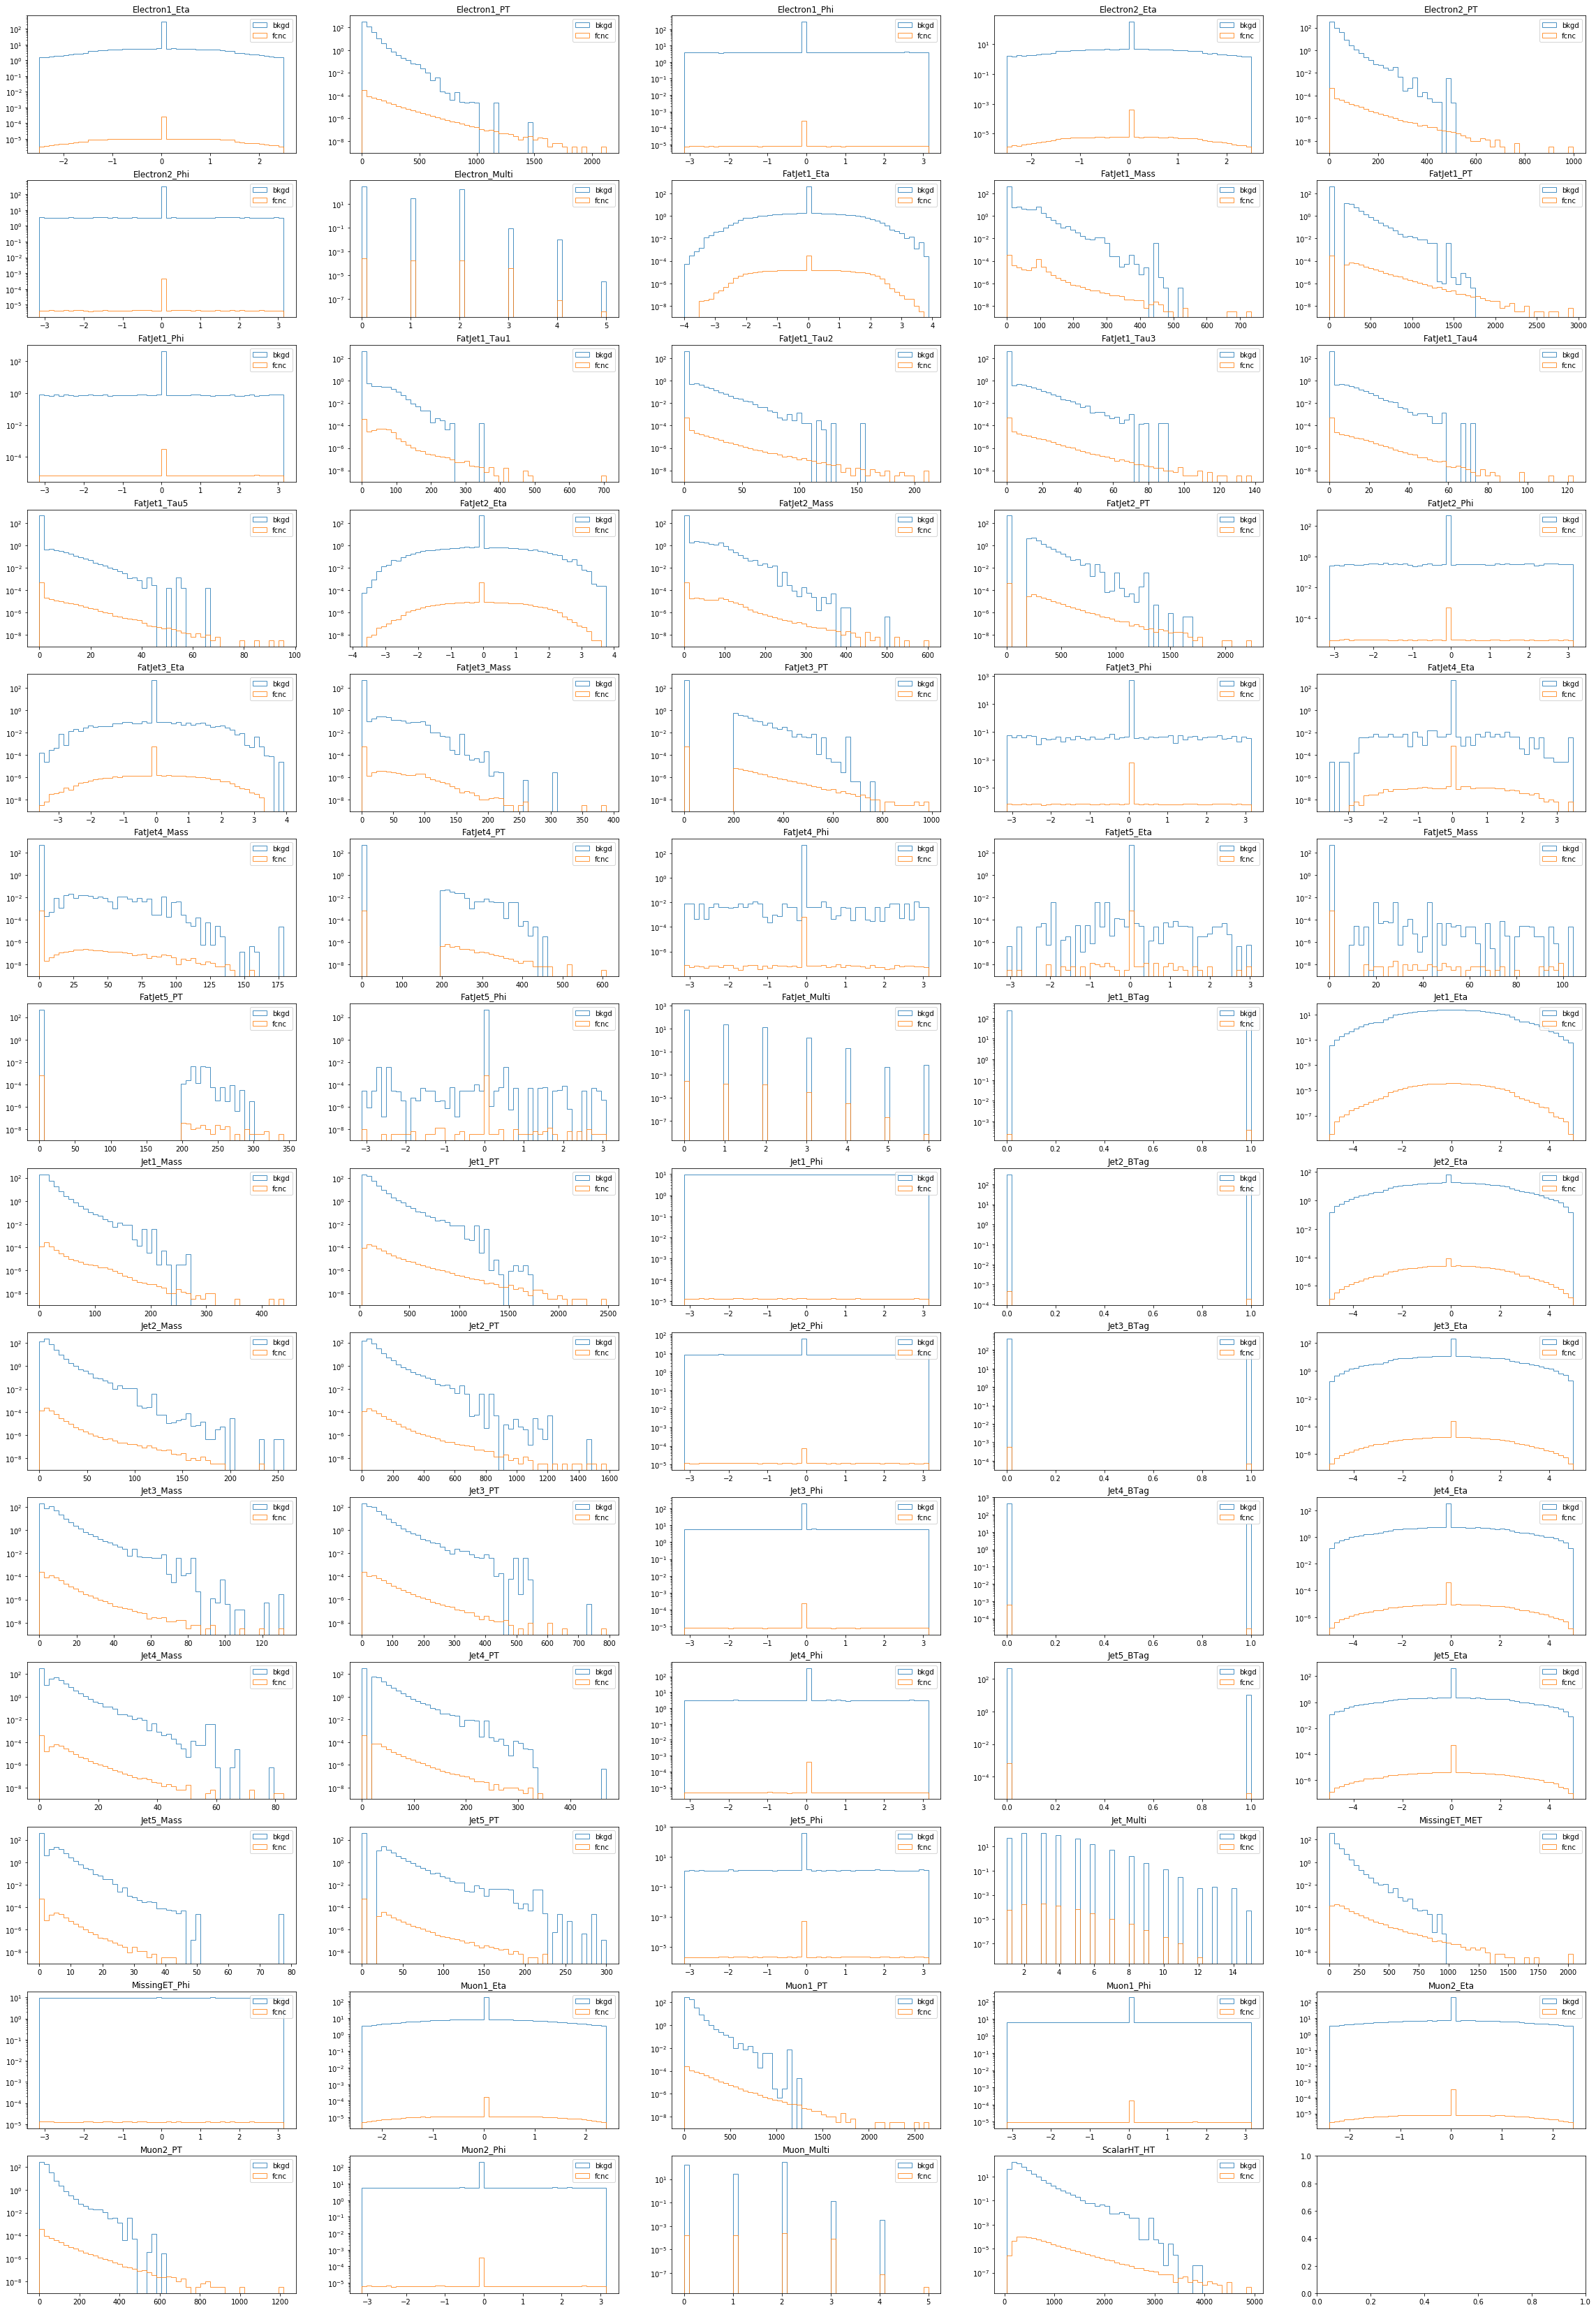

In [18]:
# Variáveis de ajuste dos plots
num_cols, bins = 5, 50

# Criar os plots
num_rows = int(np.ceil((len(list(fcnc_data.columns)) - 1) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterar e plotar cada coluna de dados
for i, column in enumerate(fcnc_data.columns):
    if fcnc_data.columns[i] != "gen_weights" and fcnc_data.columns[i] != "Label":
        # Definir a range do histograma
        hist_min = min(fcnc_data[column].min(), bkgd_data[column].min())
        hist_max = max(fcnc_data[column].max(), bkgd_data[column].max())
        hist_range = (hist_min, hist_max)

        # Dar plot aos dados
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(fcnc_data.columns[i])
        axs[row, col].hist(bkgd_data[column], bins=50, label="bkgd", alpha=0.8, range=hist_range, 
                           weights=bkgd_data["gen_weights"], histtype='step')
        axs[row, col].hist(fcnc_data[column], bins=50, label="fcnc", alpha=0.8, range=hist_range, 
                           weights=fcnc_data["gen_weights"], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()
    
plt.show()

Significado dos gráficos:
- BTag: Ocorrência ou não de jatos a partir de muões b
- Missing: Momento de partículas não detetadas que falta para se verificar a conservação de momento na colisão
- ScalarHT: Momento total (norma) missing
- [blank]_multi: quantos [blank] existem, os plots [blank]1, [blank]2, etc descrevem cada um
- Picos em zero devido esses fenómenos não serem detetados nos respetivos eventos